In [39]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import sklearn

import requests
import json

import matplotlib.pyplot as plt
import mplcyberpunk
from matplotlib import rc
import seaborn as sns

plt.style.use('cyberpunk')

plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings(action='ignore')

### Step 1. 데이터 수집 및 전처리

1-1. Fred api - gpd, interest, dept

In [397]:
from fredapi import Fred
import os

# FRED API 호출
FRED_API_KEY = os.getenv('FRED_API_KEY')
fred = Fred(api_key=FRED_API_KEY)
start_date = '1980-01-01'
end_date = '2024-12-31'

# 부채사이클
interest_payments = fred.get_series("A091RC1Q027SBEA") #Billions of Dollars
gdp = fred.get_series("GDP") #Billions of Dollars
dept = fred.get_series("GFDEBTN") #Millions of Dollars

# gdp 대비 이자비용
interest_payments_to_gdp = interest_payments / gdp
# gdp 대비 부채
dept_to_gdp = dept / gdp / 1000


# 통화량
m0 = fred.get_series("BOGMBASE") # M0
m1 = fred.get_series("M1SL") # M1
m2 = fred.get_series("M2SL") # M2
m1_to_m0 = m1 / m0 
m2_to_m0 = m2 / m0

1-2. coinmarketcap - bitcoin price, supply, market cap

In [4]:
url = "https://api.coinmarketcap.com/data-api/v3/cryptocurrency/detail/chart?id=1&timeStart=1633910400&timeEnd=1704931200"
res = requests.get(url)
bitcoin_price = res.json()['data']['points']
data_bitcoin_mc = {datetime.fromtimestamp(int(k)):v['v'] for k,v in bitcoin_price.items()}
df_bitcoin_mc =pd.DataFrame(index=data_bitcoin_mc.keys(), data=data_bitcoin_mc.values(), columns=['price', 'volume', 'market_cap','-','supply'])
df_bitcoin_mc

,price,volume,market_cap,-,supply
2010-07-14 09:00:00,0.058157,2.615400e+02,1.961800e+05,1.0,3373269.0
2010-07-22 09:00:00,0.074179,2.167060e+03,2.584294e+05,1.0,3483875.0
2010-07-30 09:00:00,0.063739,3.013580e+03,2.269748e+05,1.0,3561029.0
2010-08-06 09:00:00,0.060768,1.397310e+03,2.210160e+05,1.0,3637025.0
2010-08-14 09:00:00,0.062908,4.404590e+03,2.340858e+05,1.0,3721075.0
...,...,...,...,...,...
2024-12-05 09:00:00,98741.539382,1.492189e+11,1.954290e+12,1.0,19791975.0
2024-12-13 09:00:00,100046.650538,5.689475e+10,1.980461e+12,1.0,19795372.0
2024-12-20 09:00:00,97484.697310,1.056341e+11,1.930089e+12,1.0,19798896.0
2024-12-28 09:00:00,94160.186223,2.410744e+10,1.864805e+12,1.0,19804607.0


1-3. world gold council - gold price, mine production, mine total

In [8]:
url = 'https://fsapi.gold.org/api/v11/charts/supply-and-demand/35'
res = requests.get(url)
data_gld_mc = res.json()['chartData']['Supply_Quarterly']
df_gld_mc = pd.DataFrame({
    'date':data_gld_mc['categories'],
    'mine_production':data_gld_mc['series'][0]['data'],
    'price/oz': data_gld_mc['series'][-1]['data']
})
df_gld_mc['date'] = df_gld_mc['date'].apply(lambda x : '20'+x[-2:]+x[:2])
df_gld_mc['date'] = df_gld_mc['date'].apply(lambda x : pd.Period(x, freq='Q').to_timestamp())
df_gld_mc = df_gld_mc.set_index('date')
df_gld_mc.head()

,mine_production,price/oz
date,,
2010-01-01,632.000,1109.1
2010-04-01,674.598,1196.7
2010-07-01,729.703,1226.8
2010-10-01,718.165,1366.8
2011-01-01,667.553,1386.3


25.1 기준,
- 1t은 35274oz
- 연간 채굴량 약 3600t(분기별 900t)
- oz로 환산하면 연간 1,269,842,400oz, 분기별 31,746,600oz
- 현재(25.1.3 기준) 금은 온스(oz)당 2,634$
- 현재(25 기준) 총 금 채굴량 201,296t, 온스로 환산하면 7,100,515,104
- 시가총액은 18,702,756,783,936$  (18 trillion dollar)


In [9]:
data_gld_prod = requests.get('https://api.ourworldindata.org/v1/indicators/66252.data.json').json()
data_gld_prod_values = data_gld_prod['values']
data_gld_prod_entities = data_gld_prod['entities']
data_gld_prod_years = data_gld_prod['years']
print(len(data_gld_prod_values), len(data_gld_prod_entities), len(data_gld_prod_years))
df_gld_prod = pd.DataFrame(data={
    'years':data_gld_prod_years,
    'entities': data_gld_prod_entities, 
    'values': data_gld_prod_values})
df_gld_prod.head()

36478 36478 36478


,years,entities,values
0,1681,153,0
1,1681,155,0
2,1681,157,0
3,1681,159,0
4,1681,160,0


- https://ourworldindata.org/grapher/gold-production

In [487]:
df_gld_prod_total = (df_gld_prod.groupby('years').agg('sum')/2).cumsum().loc[2009]['values']
df_gld_mc['mine_total'] = df_gld_mc['mine_production'].cumsum() + df_gld_prod_total
df_gld_mc.head()

,mine_production,price/oz,mine_total
date,,,
2010-01-01,632.000,1109.1,143529.000
2010-04-01,674.598,1196.7,144203.598
2010-07-01,729.703,1226.8,144933.301
2010-10-01,718.165,1366.8,145651.466
2011-01-01,667.553,1386.3,146319.019


In [488]:
oz_to_ton = 35274
df_gld_mc['market_cap'] = df_gld_mc['price/oz']*df_gld_mc['mine_total']*oz_to_ton
df_gld_mc.head()

,mine_production,price/oz,mine_total,market_cap
date,,,,
2010-01-01,632.000,1109.1,143529.000,5.615198e+12
2010-04-01,674.598,1196.7,144203.598,6.087179e+12
2010-07-01,729.703,1226.8,144933.301,6.271864e+12
2010-10-01,718.165,1366.8,145651.466,7.022222e+12
2011-01-01,667.553,1386.3,146319.019,7.155051e+12


### Step 2. GDP 대비 부채율, 이자비용 기반 부채 사이클 분석

variables
- gdp
- dept
- interest_payments
- interest_payments_to_gdp
- dept_to_gdp
- m0
- m1
- m1_to_m0
- df_bitcoin_mc
- df_gld_mc

[gdp] before_startdate:1946-01-01, before_enddate:2024-07-01
[dept] before_startdate:1966-01-01, before_enddate:2024-07-01
[dept_to_gdp] before_startdate:1946-01-01, before_enddate:2024-07-01
[interest_payments] before_startdate:1947-01-01, before_enddate:2024-07-01
[interest_payments_to_gdp] before_startdate:1946-01-01, before_enddate:2024-07-01
>>[intersection] after_startdate:1966-01-01, after_enddate:2024-07-01


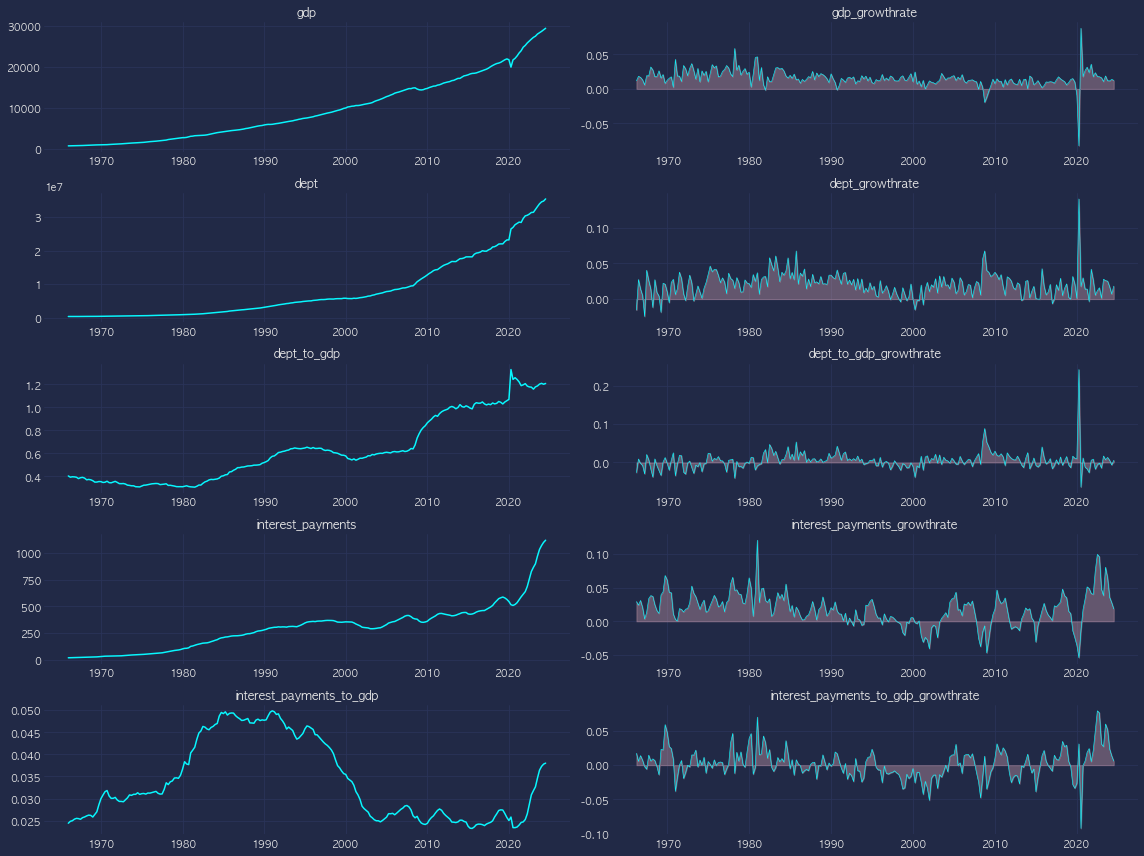

In [489]:
var_dict = {
    'gdp': gdp,
    'dept': dept,
    'dept_to_gdp': dept_to_gdp,
    'interest_payments': interest_payments,
    'interest_payments_to_gdp': interest_payments_to_gdp
}

[print(f'[{k}] before_startdate:{x.index[0].date()}, before_enddate:{x.index[-1].date()}') for k,x in var_dict.items()]
date_li = [{x.index[0].date(), x.index[-1].date()} for x in var_dict.values()]
start_date_max = max(start for start,end in date_li)
end_date_min = min(end for start,end in date_li)
print(f'>>[intersection] after_startdate:{start_date_max}, after_enddate:{end_date_min}')

for k,v in var_dict.items():
    var_dict[k] = var_dict[k][start_date_max:end_date_min]

var_gr_dict = {
    'gdp_growthrate': var_dict['gdp'].pct_change(),
    'dept_growthrate': var_dict['dept'].pct_change(),
    'dept_to_gdp_growthrate': var_dict['dept_to_gdp'].pct_change(),
    'interest_payments_growthrate': var_dict['interest_payments'].pct_change(),
    'interest_payments_to_gdp_growthrate': var_dict['interest_payments_to_gdp'].pct_change()
}

fig, axes = plt.subplots(nrows=len(var_dict.keys()), ncols=2, figsize=(16,12))


for i, (k,v) in enumerate(var_dict.items()):
    sns.lineplot(data=v,
                 x=v.index,
                 y=v.values,
                 ax=axes[i,0])
    axes[i,0].set_title(k)

for i, (k,v) in enumerate(var_gr_dict.items()):
    sns.lineplot(data=v,
                 x=v.index,
                 y=v.values,
                 ax=axes[i,1], linewidth=0.6)
    axes[i,1].fill_between(data=v, x=v.index, y1=0, y2=v.values, alpha=0.3, color='pink')
    axes[i,1].set_title(k)
    

plt.tight_layout()
plt.show()

In [490]:
var_dict['gdp']['1973Q1']

1973-01-01    1377.49
dtype: float64

In [237]:
date_li_expansion =  [
    # 1960s 황금기
    "1966", "1967", "1968", "1969",
    
    # 1980s 레이거노믹스 호황
    "1983", "1984", "1985", "1986", "1987", "1988", "1989",
    "1990Q1", "1990Q2",
    
    # 1990s 닷컴 호황
    "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999", "2000",
    "2001Q1",
    
    # 2009Q3 ~ 2020 경기 회복
    "2009Q3", "2009Q4",
    "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019",
    "2020Q1",
    
    # 2010 코로나 이후 양적완화 호황
    "2021"
]

date_li_recession = [
    # 1973Q4 ~ 1975Q1 오일 쇼크 불황
    "1973Q4", "1974", "1975Q1",
    
    # 1980Q1 ~ 1980Q2 연준 인플레 억제 정체 - 금리 상승, 경기 침체
    "1980Q1", "1980Q2", "1981Q3", "1981Q4", "1982",
    
    # 1990Q3 ~ 1991Q1 걸프전, 유가 상승
    "1990Q3", "1990Q4", "1991Q1",
    
    # 2001 닷컴 버블 붕괴, 9/11 테러
    "2001",
    
    # 2007Q4 ~ 2009Q2 글로벌 금융 위기(서브프라임 모기지)
    "2008", "2009Q1", "2009Q2",
    
    # 2020Q1 코로나19, 경제 봉쇄
    "2020Q1", "2020Q2" 
]

In [238]:
df_cycle = pd.DataFrame(index=var_dict['gdp'].index, 
                        data={'label':[np.nan]*len(var_dict['gdp'].index)})
df_cycle[date_li_expansion] = 1
df_cycle[date_li_recession] = -1
df_cycle = df_cycle.fillna(0)
df_cycle = df_cycle.astype('int64')
print(df_cycle.value_counts())
df_cycle

label
 1       131
 0        75
-1        29
dtype: int64


,label
1966-01-01,1
1966-04-01,1
1966-07-01,1
1966-10-01,1
1967-01-01,1
...,...
2023-07-01,0
2023-10-01,0
2024-01-01,0
2024-04-01,0


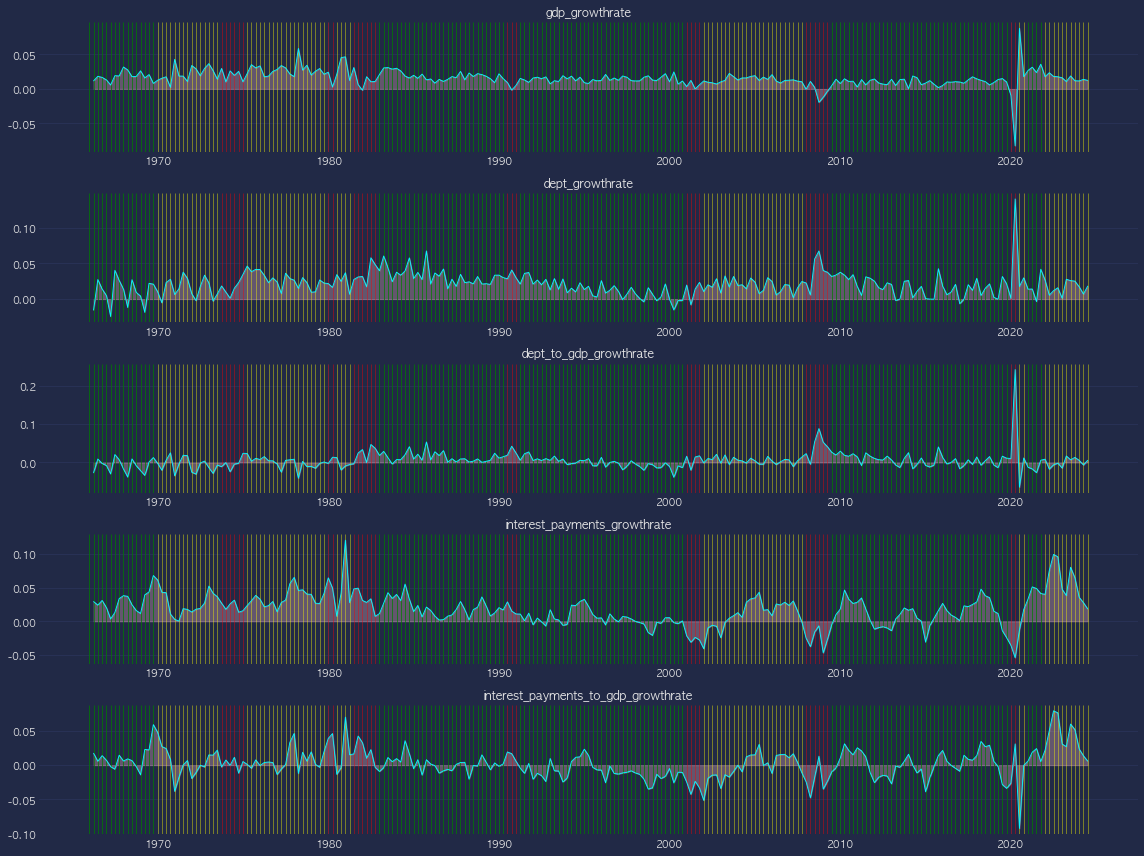

In [239]:
cmap = {
    '1': ['green',0.7],
    '-1': ['red',0.4],
    '0': ['yellow',0.4]
}

fig, axes = plt.subplots(nrows=len(var_dict.keys()), ncols=1, figsize=(16,12))

for i, (k,v) in enumerate(var_gr_dict.items()):
    sns.lineplot(data=v,
                 x=v.index,
                 y=v.values,
                 ax=axes[i], linewidth=0.9)
    axes[i].fill_between(data=v, x=v.index, y1=0, y2=v.values, alpha=0.3, color='pink')
    axes[i].set_title(k)
    for date,label in df_cycle.iterrows():
        axes[i].axvspan(xmin=v[str(date.date())[:-3]].index[0], 
                        xmax=v[str(date.date())[:-3]].index[-1], 
                        color=cmap[str(label.values[0])][0], 
                        alpha=cmap[str(label.values[0])][1])
    
plt.tight_layout() 
plt.show()

In [282]:
df_gr_w_cycle = pd.DataFrame(data={
                    'cycle': df_cycle['label'].values,
                    'gdp_growthrate': var_gr_dict['gdp_growthrate'].values,
                    'dept_growthrate': var_gr_dict['dept_growthrate'].values,
                    'dept_to_gdp_growthrate': var_gr_dict['dept_to_gdp_growthrate'].values,
                    'interest_payments_growthrate': var_gr_dict['interest_payments_growthrate'].values,
                    'interest_payments_to_gdp_growthrate': var_gr_dict['interest_payments_to_gdp_growthrate'].values
                })
df_gr_w_cycle

,cycle,gdp_growthrate,dept_growthrate,dept_to_gdp_growthrate,interest_payments_growthrate,interest_payments_to_gdp_growthrate
0,1,NaN,NaN,NaN,NaN,NaN
1,1,0.011621,-0.015271,-0.026583,0.029218,0.017395
2,1,0.018208,0.027368,0.008996,0.023990,0.005679
3,1,0.016671,0.014076,-0.002553,0.030847,0.013944
4,1,0.013042,0.004944,-0.007994,0.020265,0.007130
...,...,...,...,...,...,...
230,0,0.018718,0.025827,0.006979,0.079986,0.060142
231,0,0.011773,0.025150,0.013221,0.064396,0.052011
232,0,0.011560,0.017206,0.005582,0.035476,0.023643
233,0,0.013717,0.007087,-0.006541,0.027623,0.013717


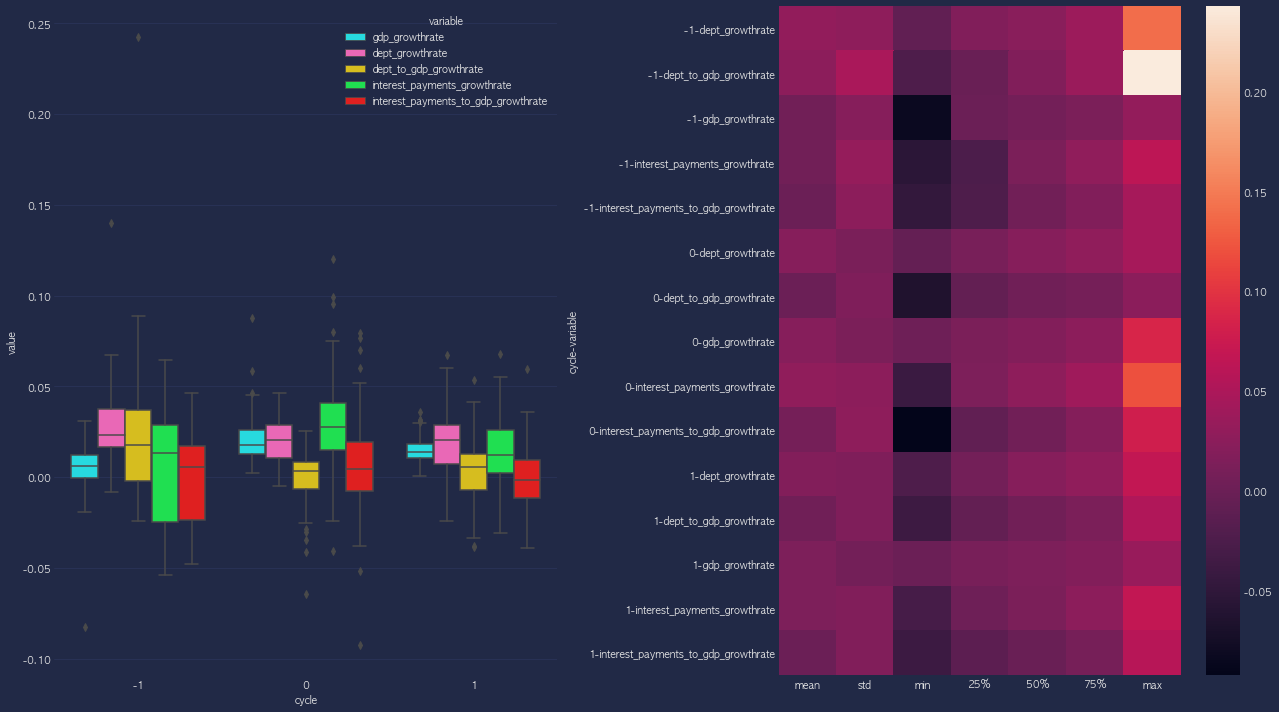

In [318]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,10))
df_gr_w_cycle_melt = pd.melt(df_gr_w_cycle, id_vars='cycle')
sns.boxplot(data=df_gr_w_cycle_melt, x='cycle', y='value', hue='variable', ax=axes[0])
sns.heatmap(df_gr_w_cycle_melt.groupby(['cycle','variable']).describe().value.iloc[:,1:], ax=axes[1])

plt.tight_layout()
plt.show()

value                      \
                                           count      mean       std   
cycle variable                                                         
-1    dept_growthrate                       29.0  0.030077  0.027384   
      dept_to_gdp_growthrate                29.0  0.025976  0.048531   
      gdp_growthrate                        29.0  0.004875  0.020787   
      interest_payments_growthrate          29.0  0.004937  0.032668   
      interest_payments_to_gdp_growthrate   29.0  0.000100  0.026369   
 0    dept_growthrate                       75.0  0.020237  0.011374   
      dept_to_gdp_growthrate                75.0 -0.000729  0.015580   
      gdp_growthrate                        75.0  0.021121  0.012810   
      interest_payments_growthrate          75.0  0.028753  0.026371   
      interest_payments_to_gdp_growthrate   75.0  0.007584  0.026935   
 1    dept_growthrate                      130.0  0.018416  0.015691   
      dept_to_gdp_growthrate               130.0  0.003552  0.015732   
      gdp_growthrate                       130.0  0.014837  0.006646   
      interest_payments_growthrate         130.0  0.014254  0.017394   
      interest_payments_to_gdp_growthrate  130.0 -0.000569  0.016208   

                                                                         \
                                                min       25%       50%   
cycle variable                                                            
-1    dept_growthrate                     -0.008127  0.016403  0.023414   
      dept_to_gdp_growthrate              -0.024237 -0.002106  0.017419   
      gdp_growthrate                      -0.082485 -0.000579  0.006198   
      interest_payments_growthrate        -0.053918 -0.025015  0.013426   
      interest_payments_to_gdp_growthrate -0.047785 -0.023657  0.005342   
 0    dept_growthrate                     -0.005142  0.010428  0.020366   
      dept_to_gdp_growthrate              -0.064406 -0.006354  0.003168   
      gdp_growthrate                       0.002347  0.012475  0.017784   
      interest_payments_growthrate        -0.040557  0.014722  0.027623   
      interest_payments_to_gdp_growthrate -0.092487 -0.007463  0.004642   
 1    dept_growthrate                     -0.024336  0.006980  0.020357   
      dept_to_gdp_growthrate              -0.038745 -0.007187  0.005338   
      gdp_growthrate                       0.000333  0.010624  0.013938   
      interest_payments_growthrate        -0.030736  0.002010  0.012224   
      interest_payments_to_gdp_growthrate -0.038863 -0.011380 -0.001424   

                                                               
                                                75%       max  
cycle variable                                                 
-1    dept_growthrate                      0.037596  0.140090  
      dept_to_gdp_growthrate               0.037030  0.242585  
      gdp_growthrate                       0.012299  0.031012  
      interest_payments_growthrate         0.028756  0.064327  
      interest_payments_to_gdp_growthrate  0.016857  0.046200  
 0    dept_growthrate                      0.028630  0.046166  
      dept_to_gdp_growthrate               0.008280  0.025269  
      gdp_growthrate                       0.026003  0.087739  
      interest_payments_growthrate         0.040706  0.119966  
      interest_payments_to_gdp_growthrate  0.019175  0.079451  
 1    dept_growthrate                      0.028555  0.067379  
      dept_to_gdp_growthrate               0.012754  0.053612  
      gdp_growthrate                       0.018325  0.035743  
      interest_payments_growthrate         0.026005  0.067711  
      interest_payments_to_gdp_growthrate  0.009518  0.059287

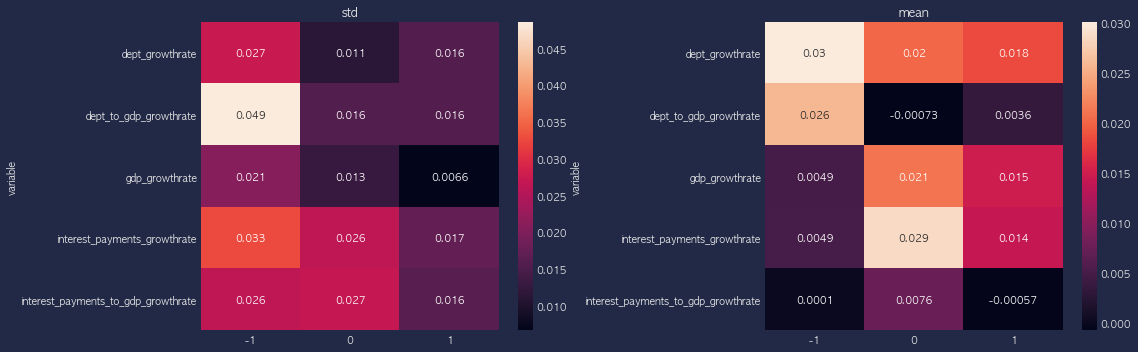

In [370]:
df_gr_w_cycle_stats = df_gr_w_cycle_melt.groupby(['cycle','variable']).describe()
display(df_gr_w_cycle_stats)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.heatmap(pd.DataFrame(
                data={'-1': df_gr_w_cycle_stats.loc[-1,'value']['std'],
                      '0': df_gr_w_cycle_stats.loc[0,'value']['std'],
                      '1': df_gr_w_cycle_stats.loc[1,'value']['std']}),
            ax=axes[0], 
            annot=True)
sns.heatmap(pd.DataFrame(
                data={'-1': df_gr_w_cycle_stats.loc[-1,'value']['mean'],
                      '0': df_gr_w_cycle_stats.loc[0,'value']['mean'],
                      '1': df_gr_w_cycle_stats.loc[1,'value']['mean']}),
            ax=axes[1],
            annot=True)

axes[0].set_title('std')
axes[1].set_title('mean')

plt.tight_layout()
plt.show()

recession 시기에는 GDP/부채/이자 성장률 지표 변동성 높음
- 부채성장률(dept_growthrate) 제외 recession으로 갈수록 모든 지표의 std가 증가.
- 부채성장률도 expansion보다 recession에서 std가 증가

평균 부채성장률은 recession 시기에 높고, 평균 이자성장률, GDP 성장률은 중립 시기에 가장 높고 recession, expansion 시기에 상대적으로 낮음

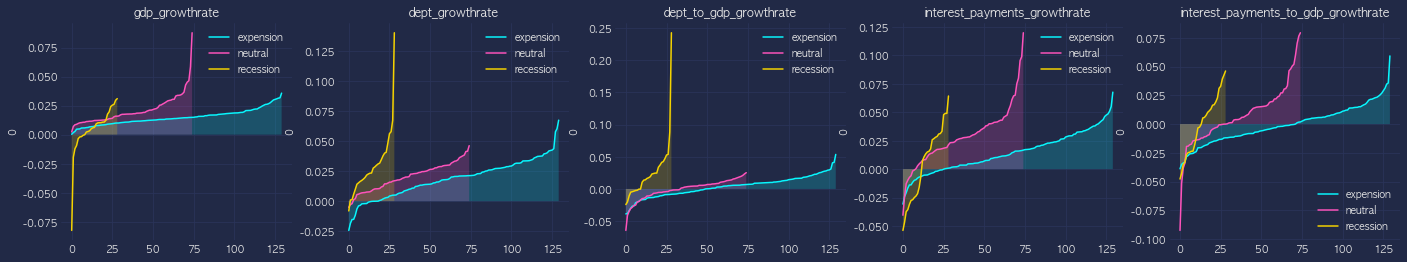

In [389]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24,4))
for i, (k,v) in enumerate(var_gr_dict.items()): 
    data_1 = (v[df_cycle[df_cycle == 1].dropna().index].sort_values()).reset_index()
    data_0 = (v[df_cycle[df_cycle == 0].dropna().index].sort_values()).reset_index()
    data_m1 = (v[df_cycle[df_cycle == -1].dropna().index].sort_values()).reset_index()
    
    sns.lineplot(data=data_1, x=data_1.index, y=data_1.iloc[:,1], label='expension', ax=axes[i])
    axes[i].fill_between(x=data_1.index, y1=0, y2=data_1.iloc[:,1], alpha=0.2)
    sns.lineplot(data=data_0, x=data_0.index, y=data_0.iloc[:,1], label='neutral', ax=axes[i])
    axes[i].fill_between(x=data_0.index, y1=0, y2=data_0.iloc[:,1], alpha=0.2)
    sns.lineplot(data=data_m1, x=data_m1.index, y=data_m1.iloc[:,1], label='recession', ax=axes[i])
    axes[i].fill_between(x=data_m1.index, y1=0, y2=data_m1.iloc[:,1], alpha=0.2)
    
    axes[i].set_title(k)
    axes[i].legend()

plt.show()

- gdp 성장률: recession에 극하방, neutral에 상방, expansion에서 안정적인 낮은 상방 유지
- dept 성장률: recession에 극상방, neutral에 상방, expansion에서 neutral과 유사한 수준
- gdp 대비 dept 성장률: recession에 극상방, neutral과 expansion 낮은 상방
- 이자비용 성장률: neutral에 극상방, recession과 expansion 낮은 상방
- gdp 대비 이자비용 성장률: neutral에 상~하방 열림. 

확실히 부채성장률은 문제가 됨. recession 시기에 극명히 다름. 또, recession 시기에 gdp 성장률 굉장히 꺾임.

In [648]:
recession_start_months = df_cycle[df_cycle[df_cycle.diff() <= -1] == -1].dropna().index

recession_before_months = []
recession_before_months.append(recession_start_months - pd.DateOffset(months=1))
recession_before_months.append(recession_start_months - pd.DateOffset(months=2))
recession_before_months.append(recession_start_months - pd.DateOffset(months=3))
recession_before_months = pd.to_datetime([date for dt_index in recession_before_months for date in dt_index])
recession_before_months = recession_before_months.sort_values()
recession_before_months

DatetimeIndex(['1973-07-01', '1973-08-01', '1973-09-01', '1979-10-01',
               '1979-11-01', '1979-12-01', '1981-04-01', '1981-05-01',
               '1981-06-01', '1990-04-01', '1990-05-01', '1990-06-01',
               '2000-10-01', '2000-11-01', '2000-12-01', '2007-10-01',
               '2007-11-01', '2007-12-01', '2019-10-01', '2019-11-01',
               '2019-12-01'],
              dtype='datetime64[ns]', freq=None)

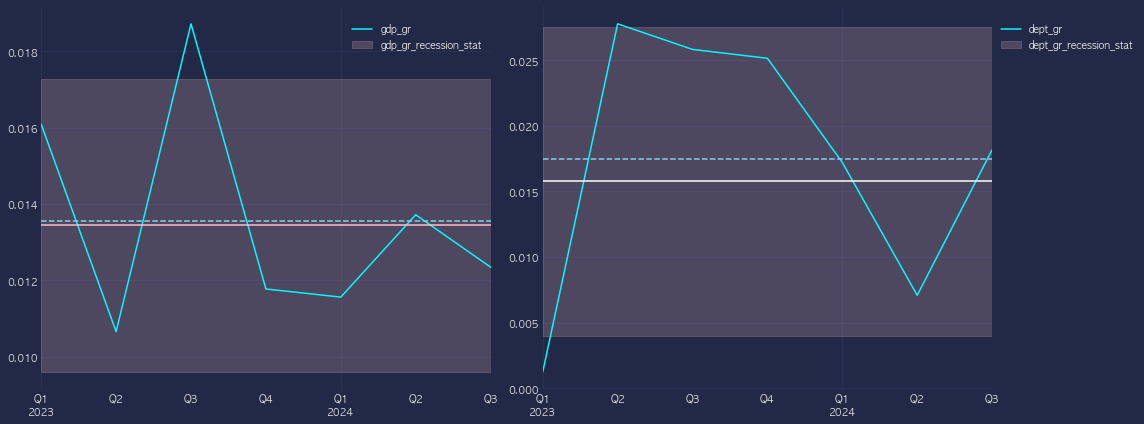

In [699]:
gdp_gr_recesshiststat = var_gr_dict['gdp_growthrate'].reindex(recession_before_months).dropna().describe()
dept_gr_recesshiststat = var_gr_dict['dept_growthrate'].reindex(recession_before_months).dropna().describe()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
var_gr_dict['gdp_growthrate']['2023':].plot(label='gdp_gr', ax=axes[0])
axes[0].axhline(y=var_gr_dict['gdp_growthrate']['2023':].mean(), color='skyblue', linestyle='--')
axes[0].axhline(y=gdp_gr_recesshiststat['mean'], color='pink')
axes[0].axhspan(ymin=gdp_gr_recesshiststat['mean']-gdp_gr_recesshiststat['std'],
                ymax=gdp_gr_recesshiststat['mean']+gdp_gr_recesshiststat['std'],
                alpha=0.2,
                color='pink',
                label='gdp_gr_recession_stat')
axes[0].legend(bbox_to_anchor=(1,0.98))

var_gr_dict['dept_growthrate']['2023':].plot(label='dept_gr', ax=axes[1])
axes[1].axhline(y=var_gr_dict['dept_growthrate']['2023':].mean(), color='skyblue', linestyle='--')
axes[1].axhline(y=dept_gr_recesshiststat['mean'])
axes[1].axhspan(ymin=dept_gr_recesshiststat['mean']-dept_gr_recesshiststat['std'],
                ymax=dept_gr_recesshiststat['mean']+dept_gr_recesshiststat['std'],
                alpha=0.2,
                color='pink',
                label='dept_gr_recession_stat')
axes[1].legend(bbox_to_anchor=(1,0.98))


plt.tight_layout()
plt.show()

In [696]:
expansion_start_months = df_cycle[df_cycle[df_cycle.diff() >= 1] == 1].dropna().index

expansion_before_months = []
expansion_before_months.append(expansion_start_months - pd.DateOffset(months=1))
expansion_before_months.append(expansion_start_months - pd.DateOffset(months=2))
expansion_before_months.append(expansion_start_months - pd.DateOffset(months=3))
expansion_before_months = pd.to_datetime([date for dt_index in expansion_before_months for date in dt_index])
expansion_before_months = expansion_before_months.sort_values()
expansion_before_months

DatetimeIndex(['1982-10-01', '1982-11-01', '1982-12-01', '1991-01-01',
               '1991-02-01', '1991-03-01', '2009-04-01', '2009-05-01',
               '2009-06-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq=None)

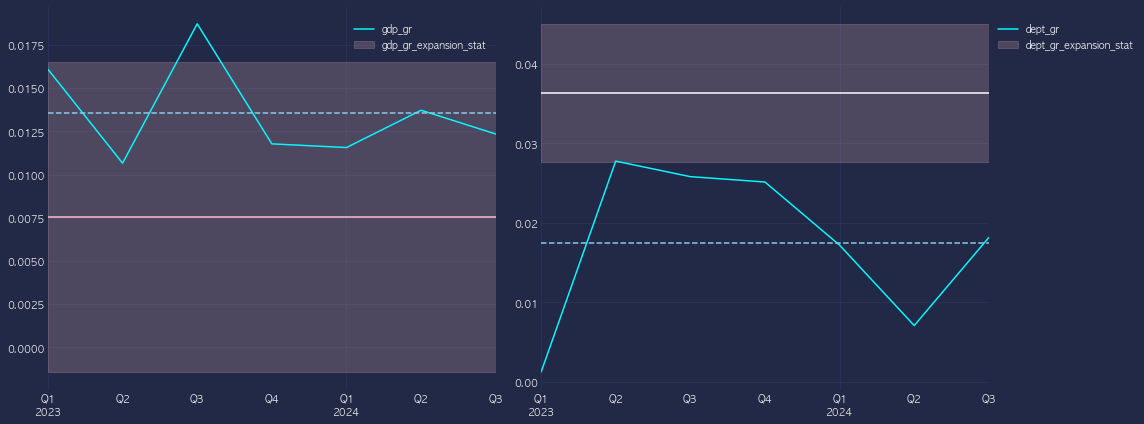

In [698]:
gdp_gr_expanshiststat = var_gr_dict['gdp_growthrate'].reindex(expansion_before_months).dropna().describe()
dept_gr_expanshiststat = var_gr_dict['dept_growthrate'].reindex(expansion_before_months).dropna().describe()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
var_gr_dict['gdp_growthrate']['2023':].plot(label='gdp_gr', ax=axes[0])
axes[0].axhline(y=var_gr_dict['gdp_growthrate']['2023':].mean(), color='skyblue', linestyle='--')
axes[0].axhline(y=gdp_gr_expanshiststat['mean'], color='pink')
axes[0].axhspan(ymin=gdp_gr_expanshiststat['mean']-gdp_gr_expanshiststat['std'],
                ymax=gdp_gr_expanshiststat['mean']+gdp_gr_expanshiststat['std'],
                alpha=0.2,
                color='pink',
                label='gdp_gr_expansion_stat')
axes[0].legend(bbox_to_anchor=(1,0.98))

var_gr_dict['dept_growthrate']['2023':].plot(label='dept_gr', ax=axes[1])
axes[1].axhline(y=var_gr_dict['dept_growthrate']['2023':].mean(), color='skyblue', linestyle='--')
axes[1].axhline(y=dept_gr_expanshiststat['mean'])
axes[1].axhspan(ymin=dept_gr_expanshiststat['mean']-dept_gr_expanshiststat['std'],
                ymax=dept_gr_expanshiststat['mean']+dept_gr_expanshiststat['std'],
                alpha=0.2,
                color='pink',
                label='dept_gr_expansion_stat')
axes[1].legend(bbox_to_anchor=(1,0.98))


plt.tight_layout()
plt.show()

- expansion 직전 3개월보다 recession 직전 3개월 통계와 유사함.
- recession에 대비해야 함.

- 다만 과거 통계치를 그대로 사용하는 것 역시 문제가 있을 수 있습니다. 예를 들어, 2008년 금융위기 이후의 경제 상황은 2008년 금융위기 이전과는 매우 다르기 때문입니다. 이러한 문제를 해결하기 위해서는, 과거 통계치를 사용하는 것이 아닌, 현재의 경제 상황을 반영한 통계치를 사용해야 합니다.

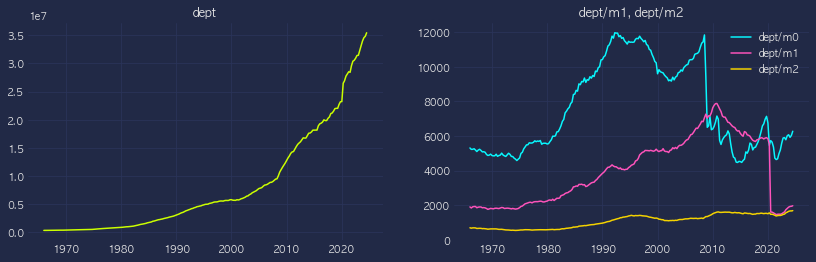

In [607]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4))

axes[0].plot(dept, color='#CCFF00')
axes[0].set_title('dept')

axes[1].plot((dept/m0).dropna(), label='dept/m0')
axes[1].plot((dept/m1).dropna(), label='dept/m1')
axes[1].plot((dept/m2).dropna(), label='dept/m2')
axes[1].set_title('dept/m1, dept/m2')

axes[1].legend()
plt.show()

돈을 찍어내는 것이 미국 부채를 희석시키는 효과를 가질 수는 있지만, 그 방식은 인플레이션을 통한 화폐 가치 하락을 이용하는 것입니다. 하지만 이 효과는 단기적인 현상일 수 있으며, 장기적으로는 과도한 통화 공급이 경제 불안정과 금리 상승, 그리고 국제적인 신뢰 상실을 초래할 수 있습니다.

결국, 부채 문제를 해결하려면 단기적인 통화 공급 증가보다는 지속 가능한 경제 성장, 재정 건전성 확보, 적극적인 부채 관리가 필요합니다.

이렇게 통화승수를 고려하면 부채는 상당수 희석되기 때문에.

### Step 3. 부채사이클별 M0, M1 통화 증가율과 금 가격간 인과 추론

- 참고) 우리나라의 경우 1979년까지 주로 M1을 기준으로 통화량을 관리했다. 이후 경제 규모가 커지고 다양한 금융기관이 출현하면서 M1이 실물경제의 동향을 제대로 반영하지 못한다고 판단돼 M2를 기준 통화지표로 사용하고 있다. M1은 측정이 정확하고 편리한 장점이 있지만, 실물경제의 규모를 정확히 반영하지 못하는 문제가 발생해 우리나라를 비롯한 많은 나라에서 M2를 기준 통화지표로 사용하고 있다. 최근에는 금융의 발전으로 가상화폐를 비롯해 금융상품이 더 다양해지고 있다. 그뿐 아니라 금융시장의 구조도 급격히 변해가는 상황에서 M2도 실물경제와 괴리가 많이 발생하고 있어 한층 더 포괄적인 통화지표를 사용해야 한다는 주장이 제기되고 있다.

In [392]:
df_cycle

,label
1966-01-01,1
1966-04-01,1
1966-07-01,1
1966-10-01,1
1967-01-01,1
...,...
2023-07-01,0
2023-10-01,0
2024-01-01,0
2024-04-01,0


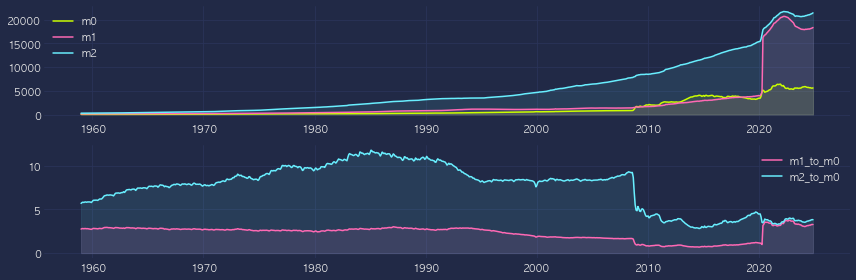

In [475]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,4))

sns.lineplot(data=m0,x=m0.index,y=m0.values,ax=axes[0], label='m0', color='#CCFF00')
axes[0].fill_between(x=m0.index, y1=0, y2=m0.values, alpha=0.1, color='#CCFF00')
sns.lineplot(data=m1,x=m1.index,y=m1.values,ax=axes[0], label='m1', color='#FF69B4')
axes[0].fill_between(x=m1.index, y1=0, y2=m1.values, alpha=0.1, color='#FF69B4')
sns.lineplot(data=m2,x=m2.index,y=m2.values,ax=axes[0], label='m2', color='#69EFFF')
axes[0].fill_between(x=m2.index, y1=0, y2=m2.values, alpha=0.1, color='#69EFFF')

sns.lineplot(data=m1_to_m0,x=m1_to_m0.index,y=m1_to_m0.values,ax=axes[1], label='m1_to_m0', color='#FF69B4')
axes[1].fill_between(x=m1_to_m0.index, y1=0, y2=m1_to_m0.values, alpha=0.1, color='#FF69B4')
sns.lineplot(data=m2_to_m0,x=m2_to_m0.index,y=m2_to_m0.values,ax=axes[1], label='m2_to_m0', color='#69EFFF')
axes[1].fill_between(x=m2_to_m0.index, y1=0, y2=m2_to_m0.values, alpha=0.1, color='#69EFFF')


plt.tight_layout()
plt.show()

통화승수 하락 요인:
- 높은 지급준비율
- 경제 불확실성 및 금융 위기
- 중앙은행의 긴축적 통화정책
- 은행들의 지급준비금 선호 증가

통화 승수 하락 시:
- 유동성 함정(Liquidity Trap):
    - 중앙은행이 본원통화를 늘려도 은행들이 대출을 줄이고 준비금을 쌓아두면, 경제 전체의 통화량이 증가하지 않아 경기 부양 효과가 제한됩니다.
- 경제 성장 둔화:
    - 신용 창출이 줄어들어 기업과 개인의 대출 접근성이 낮아지고, 투자와 소비가 위축되어 경제 성장률이 둔화될 수 있습니다.
- 디플레이션 위험:
    - 통화량 증가가 제한되면 수요 감소로 인해 가격이 하락(디플레이션)할 위험이 높아집니다.

2020 돈을 대규모로 풀었고, m0대비 m1 통화승수는 증가했으나 m0 대비 m2 통화승수는 그렇지 않다.
돈을 풀어서 은행에 단기예금으로 많이 유입되었으나, 장기 예금이나 적금 등 은행 예치 상품으로 묶기보다 비은행 금융 자산으로 이동하고 있음.

- M1 승수의 급격한 증가는 사람들이 현금을 덜 보유하고 요구불예금과 같은 단기 거래 수단을 선호하고 있음을 나타내며, 이는 거래와 소비가 활발해지고 있음을 반영합니다.
- M2 승수의 감소 또는 정체는 자금이 은행 중심의 장기 예금에서 벗어나 비은행 금융 자산으로 이동하고 있다는 신호로, 이는 금융 시장의 성장과 동시에 전통적인 은행 시스템의 축소를 의미합니다.


In [480]:
df_gld_mc['price/oz']

date
2010-01-01    1109.1
2010-04-01    1196.7
2010-07-01    1226.8
2010-10-01    1366.8
2011-01-01    1386.3
2011-04-01    1506.1
2011-07-01    1702.1
2011-10-01    1688.0
2012-01-01    1690.6
2012-04-01    1609.5
2012-07-01    1652.0
2012-10-01    1721.8
2013-01-01    1631.8
2013-04-01    1414.8
2013-07-01    1326.3
2013-10-01    1276.2
2014-01-01    1293.1
2014-04-01    1288.4
2014-07-01    1281.9
2014-10-01    1201.4
2015-01-01    1218.5
2015-04-01    1192.4
2015-07-01    1124.3
2015-10-01    1106.5
2016-01-01    1182.6
2016-04-01    1259.6
2016-07-01    1334.8
2016-10-01    1221.6
2017-01-01    1219.5
2017-04-01    1256.6
2017-07-01    1277.9
2017-10-01    1275.4
2018-01-01    1329.3
2018-04-01    1306.0
2018-07-01    1213.2
2018-10-01    1226.3
2019-01-01    1303.8
2019-04-01    1309.4
2019-07-01    1472.5
2019-10-01    1481.0
2020-01-01    1582.8
2020-04-01    1711.1
2020-07-01    1908.6
2020-10-01    1874.2
2021-01-01    1794.0
2021-04-01    1816.5
2021-07-01    1789.5
2021-10-

### 통화량 증가율 대비 금 증가율


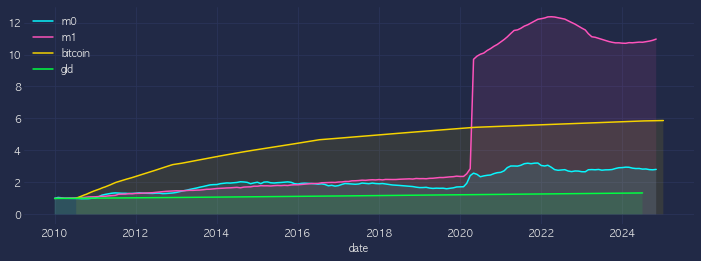

In [564]:

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

data_m0 = (m0['2010':] / m0['2010':].iloc[0])
sns.lineplot(data=data_m0, x=data_m0.index, y=data_m0.values, ax=axes, label='m0')
axes.fill_between(x=data_m0.index, y1=0, y2=data_m0.values, alpha=0.1)

data_m1 = (m1['2010':] / m1['2010':].iloc[0])
sns.lineplot(data=data_m1, x=data_m1.index, y=data_m1.values, ax=axes, label='m1')
axes.fill_between(x=data_m1.index, y1=0, y2=data_m1.values, alpha=0.1)

data_bitcoin = (df_bitcoin_mc['supply']['2010':] / df_bitcoin_mc['supply']['2010':].iloc[0])
sns.lineplot(data=data_bitcoin, x=data_bitcoin.index, y=data_bitcoin.values, ax=axes, label='bitcoin')
axes.fill_between(x=data_bitcoin.index, y1=0, y2=data_bitcoin.values, alpha=0.1)

data_gld = (df_gld_mc['mine_total'] / df_gld_mc['mine_total'].iloc[0])
sns.lineplot(data=data_gld, x=data_gld.index, y=data_gld.values, ax=axes, label='gld')
axes.fill_between(x=data_gld.index, y1=0, y2=data_gld.values, alpha=0.1)

plt.show()

In [ ]:
- 금 누적 채굴량 증가 비율은 통화량 증가율대비 매우 낮음.
- 통화량ㅇ

In [531]:
data0.index

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01'],
              dtype='datetime64[ns]', length=179, freq=None)

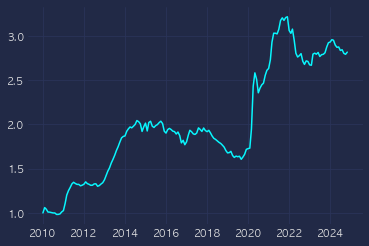

In [550]:
sns.lineplot(data=data0, x=data0.index, y=data0.values)

plt.show()

In [523]:
data1

date
2010-01-01    1.000000
2010-04-01    1.004700
2010-07-01    1.009784
2010-10-01    1.014788
2011-01-01    1.019439
2011-04-01    1.024453
2011-07-01    1.029697
2011-10-01    1.034831
2012-01-01    1.039610
2012-04-01    1.044692
2012-07-01    1.050053
2012-10-01    1.055435
2013-01-01    1.060456
2013-04-01    1.065823
2013-07-01    1.071668
2013-10-01    1.077503
2014-01-01    1.082725
2014-04-01    1.088247
2014-07-01    1.094257
2014-10-01    1.100297
2015-01-01    1.105787
2015-04-01    1.111629
2015-07-01    1.117675
2015-10-01    1.123724
2016-01-01    1.129684
2016-04-01    1.135682
2016-07-01    1.141833
2016-10-01    1.148222
2017-01-01    1.154016
2017-04-01    1.160184
2017-07-01    1.166634
2017-10-01    1.173169
2018-01-01    1.179103
2018-04-01    1.185372
2018-07-01    1.192032
2018-10-01    1.198658
2019-01-01    1.204559
2019-04-01    1.210696
2019-07-01    1.217213
2019-10-01    1.223775
2020-01-01    1.229636
2020-04-01    1.235142
2020-07-01    1.241580
2020-1

In [522]:
data0

2010-01-01    1.000000
2010-02-01    1.060251
2010-03-01    1.042406
2010-04-01    1.009724
2010-05-01    1.008672
                ...   
2024-07-01    2.833985
2024-08-01    2.842206
2024-09-01    2.801203
2024-10-01    2.790576
2024-11-01    2.815288
Length: 179, dtype: float64

In [517]:
data

2010-01-01    1.000000
2010-02-01    1.060251
2010-03-01    1.042406
2010-04-01    1.009724
2010-05-01    1.008672
                ...   
2024-07-01    2.833985
2024-08-01    2.842206
2024-09-01    2.801203
2024-10-01    2.790576
2024-11-01    2.815288
Length: 179, dtype: float64

<AxesSubplot:xlabel='date'>

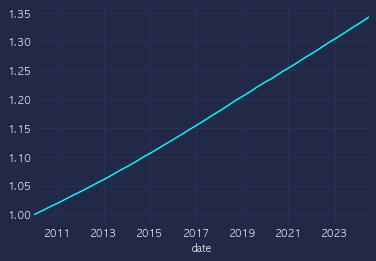

In [506]:
(df_gld_mc['mine_total'] / df_gld_mc['mine_total'].iloc[0]).plot()

<AxesSubplot:>

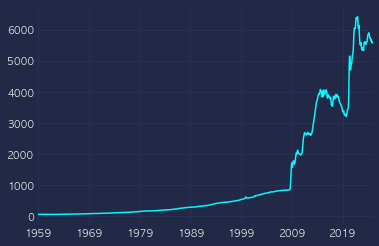

In [396]:
m0.plot()

In [391]:
m

1959-01-01      50.5
1959-02-01      49.8
1959-03-01      49.7
1959-04-01      50.1
1959-05-01      50.1
               ...  
2024-07-01    5653.8
2024-08-01    5670.2
2024-09-01    5588.4
2024-10-01    5567.2
2024-11-01    5616.5
Length: 791, dtype: float64

### Step 4. 금, 비트코인 시가총액 시계열 연관성 분석

### Step 5. 미래 비트코인 시가총액 예측 및 현재 적정가 산출